## CX4240 project

## Classification of Acute Lymphoblastic Leukemia (ALL) in Blood Cell Images Using Machine Learning

# Feature Extractions


In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.stats as stat
import sklearn.preprocessing as pre
import glob
import mahotas as mt
import pywt
import seaborn as sns
import pandas as pd
import csv 
import matplotlib as mpl

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
%matplotlib inline


# Load Images

In [2]:
def find_path(stage, fold=None, label=None):
    """
    This function finds the path on a local computer for the images we wish to 
    examine (indicated by the arguments). We upload the images from a local computer 
    rather than Github because the dataset is too large to put on Github.
    
    args:  
        stage: 'train' or 'test'
        fold: int
        label: 'all' or 'hem'
    returns: 
        general file path for given inputs
    """

    og_path = '/Users/pdgalonsky/Documents/GA Tech/Summer 2019/Computational Data Analysis/final project/C-NMC_Leukemia/'
    if stage == 'train':
        return og_path + 'C-NMC_training_data/fold_' + str(fold) + '/' + label + '/*.bmp'
    elif stage == 'test':
        return og_path + 'C-NMC_test_prelim_phase_data/'*2 + '*.bmp'
    else:
        print('must enter "train" or "test"')
        return

def read_images(stage, fold=None, label=None):
    """
    This function reads the images stored on a local computer from the
    stage (train or test), fold and label(all or hem) specified. It returns 
    three numpy arrays of the color, grayscale and binary images respectively.
    It also returns a list of the ids of images, which is useful because the
    images are not loaded in order. 
    
    args:    
        stage: 'train' or 'test'
        fold: 0, 1 or 2, int
        label: 'all' or 'hem'
    returns: 
        color: numpy array of color images
        gray: numpy array of gray images
        binary: numpy array of binary images
        ids: list of associated image ids
    """
    
    img_path = find_path(stage, fold, label)
    start = len(img_path) - 5
    color, gray, ids = [], [], []
    for name in glob.glob(img_path):
        ids.append(name[start : -4])
        color.append(cv2.imread(name))
        gray.append(cv2.imread(name,0))
    color = np.array(color)
    gray = np.array(gray)
    ret, binary = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
    if stage=='train':
        print('done loading training %s images in fold%s' % (label,str(fold)))
    else:
        print('done loading test images')
    return color, gray, binary, ids

In [3]:
# load train images
ALL_0_color, ALL_0_gray, ALL_0_binary, ALL_0_ids = read_images('train', 0, 'all')
hem_0_color, hem_0_gray, hem_0_binary, hem_0_ids = read_images('train', 0, 'hem')
ALL_1_color, ALL_1_gray, ALL_1_binary, ALL_1_ids = read_images('train', 1, 'all')
hem_1_color, hem_1_gray, hem_1_binary, hem_1_ids = read_images('train', 1, 'hem')
ALL_2_color, ALL_2_gray, ALL_2_binary, ALL_2_ids = read_images('train', 2, 'all')
hem_2_color, hem_2_gray, hem_2_binary, hem_2_ids = read_images('train', 2, 'hem')

# store the train images from all folds together, but separated by label
ALL_0_color = np.concatenate((ALL_0_color,ALL_1_color,ALL_2_color), axis=0)
ALL_0_gray = np.concatenate((ALL_0_gray,ALL_1_gray,ALL_2_gray), axis=0)
ALL_0_binary = np.concatenate((ALL_0_binary,ALL_1_binary,ALL_2_binary), axis=0)
hem_0_color = np.concatenate((hem_0_color,hem_1_color,hem_2_color), axis=0)
hem_0_gray = np.concatenate((hem_0_gray,hem_1_gray,hem_2_gray), axis=0)
hem_0_binary = np.concatenate((hem_0_binary,hem_1_binary,hem_2_binary), axis=0)


done loading training all images in fold0
done loading training hem images in fold0
done loading training all images in fold1
done loading training hem images in fold1
done loading training all images in fold2
done loading training hem images in fold2


In [4]:
# load test data
t_color, t_gray, t_binary, test_ids = read_images('test', 0)
test_ids = np.asarray(test_ids, dtype=int)
test_color = np.zeros(np.shape(t_color), dtype=np.uint8)
test_gray = np.zeros(np.shape(t_gray), dtype=np.uint8)
test_binary = np.zeros(np.shape(t_binary), dtype=np.uint8)

# put the test data in order
test_color[test_ids-1] = t_color
test_gray[test_ids-1] = t_gray
test_binary[test_ids-1] = t_binary

done loading test images


In [5]:
# number of images
n_ALL = len(ALL_0_color)
n_hem = len(hem_0_color)
n_test = len(test_color)

# shape of images
print(np.shape(ALL_0_color))
print(np.shape(hem_0_color))
print(np.shape(test_color))

(7272, 450, 450, 3)
(3389, 450, 450, 3)
(1867, 450, 450, 3)


(<matplotlib.axes._subplots.AxesSubplot at 0x1a20ecb9e8>,
 Text(0.5, 1.0, 'Normal binary'))

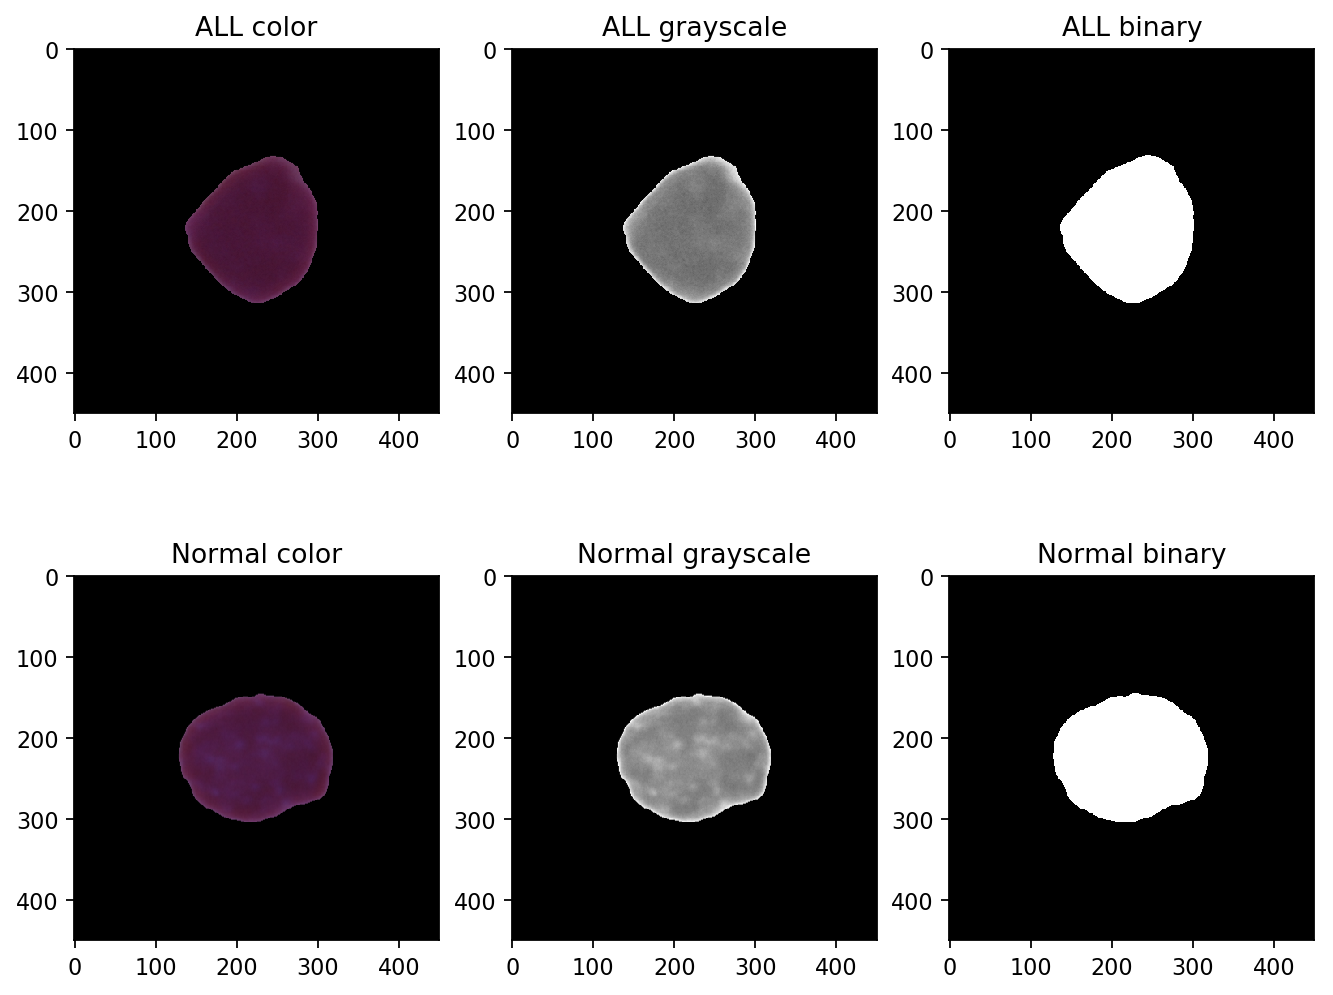

In [6]:
# plot some images that we have stored
plt.figure(num=None, figsize=(10, 8), dpi=160, facecolor='w', edgecolor='k')
plt.subplot(2,3,1), plt.imshow(ALL_0_color[172]), plt.title('ALL color')
plt.subplot(2,3,2), plt.imshow(ALL_0_gray[172],'gray'), plt.title('ALL grayscale')
plt.subplot(2,3,3), plt.imshow(ALL_0_binary[172],'gray'), plt.title('ALL binary')
plt.subplot(2,3,4), plt.imshow(hem_0_color[127]), plt.title('Normal color')
plt.subplot(2,3,5), plt.imshow(hem_0_gray[127],'gray'), plt.title('Normal grayscale')
plt.subplot(2,3,6), plt.imshow(hem_0_binary[127],'gray'), plt.title('Normal binary')

Text(0.5, 0.98, 'Normal Cells')

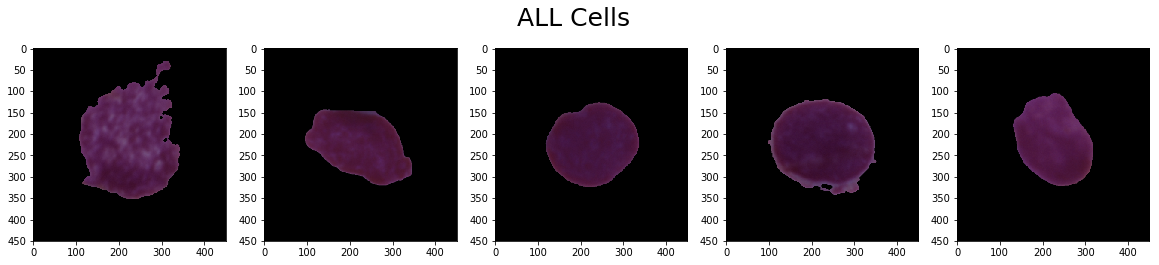

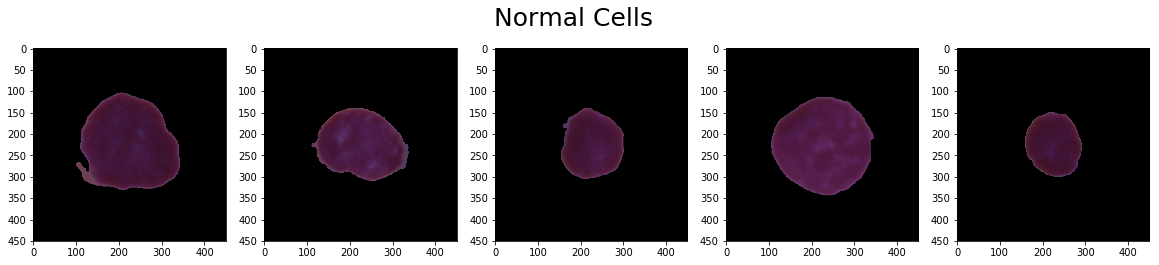

In [7]:
# plot more images that we have stored
plt.figure(figsize = (20, 4))
for i, j in enumerate(np.random.randint(n_ALL, size = 5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(ALL_0_color[j])
plt.suptitle('ALL Cells', fontsize=25)

plt.figure(figsize = (20, 4))
for i, j in enumerate(np.random.randint(n_hem, size = 5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(hem_0_color[j])
plt.suptitle('Normal Cells', fontsize=25)


# Feature extraction
    F1: cell size
    F2: perimeter
    F3: form factor
    F4: roundness
    F5: length/diameter ratio
    F6: compactness
    F7-F9: contour signature of nucleus: 
        variance, skewness, and kurtosis of the distances between centroid and contour points
    F10-F22: Haralick texture 
        angular second moment
        contrast
        correlation
        variance
        inverse difference moment
        sum average
        sum variance
        sum entropy
        difference entropy
        information measures of correlation (F12, F13)
    F23-30: Haar wavelet texture
        Means and variances of low-pass filtered appriximation image 
        and high-pass filterd in horizontal, vertical, and diagonal directions
    F31-F36: color features
        Means in RGB
        Means in HSV



In [8]:
features = ['Cell Size','Perimeter','Form Factor','Roundness','Length/Diameter Ratio','Compactness',
            'Boundary Roughness Variance','Boundary Roughness Skewness','Boundary Roughness Kurtosis',
            'Haralick Angular Second Moment','Haralick Contrast','Haralick Correlation','Haralick Variance',
            'Haralick Inverse Difference Moment','Haralick Sum Average','Haralick Sum Variance',
            'Haralick Sum Entropy','Haralick Entropy','Haralick Difference Variance','Haralick Difference Entropy',
            'Haralick Information Measures of Correlation 1','Haralick Information Measures of Correlation 2',
            'Wavelet Approximation Mean','Wavelet Horizontal Mean','Wavelet Vertical Mean','Wavelet Diagonal Mean',
            'Wavelet Approximation Variance', 'Wavelet Horizontal Variance','Wavelet Vertical Variance',
            'Wavelet Diagonal Variance','Red Mean','Green Mean','Blue Mean','Hue Mean','Saturation Mean','Value Mean',
            'Intensity Mean','Intensity Variance']

## Morphological feature extraction

In [9]:
def get_cell_size(image):
    """
    args:    
        image: numpy array of N binary images
    returns:
        size: numpy array of the number of pixels in each cell
    """
    return np.count_nonzero(image, axis=(1,2))


def get_cell_perimeter(image):
    """
    args:    
        image: numpy array of N binary images
    returns:
        perimeter: numpy array of the number of pixels 
                   in the perimeter of each cell
        cnt: x,y coordiantes of boundary (list)
    """
    perimeter = np.zeros(len(image))
    cnt = []
    for i in range(len(image)):
        _, contour, _ = cv2.findContours(image[i], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        perimeter[i] = contour[0].shape[0]
        cnt.append(contour[0])
    return perimeter, cnt


def get_centeroid(image):
    """
    args:
        image: numpy array of N binary images
    returns:
        cx: x coordinate of center (numpy array)
        cy: y coordinate of center (numpy array)
    """
    cx = np.zeros(len(image), dtype=int)
    cy = np.zeros(len(image), dtype=int)
    for i in range(len(image)):
        M = cv2.moments(image[i])
        cx[i] = int(M['m10']/M['m00'])
        cy[i] = int(M['m01']/M['m00'])
    return cx,cy
    
    
def get_diameter(image):
    """
    args:
        image: numpy array of N binary images
    returns: 
        major_d: the maximum diameter (number of pixels) on the major axis 
        minor_d: the diameter (number of pixels) on the minor axis (perpendicular to the major axis)
        min_d: the minimum diameter 
    """
    (rows, cols) = image[0].shape[:2] 
    major_d = np.zeros(len(image))
    minor_d = np.zeros(len(image))
    min_d = rows*np.ones(len(image))
    major_img = np.zeros(np.shape(image))
    minor_img = np.zeros(np.shape(image))
    for i in range(len(image)):
        for ang in range(0,180,10):
            # Images are rotated 0 to 170 degrees with the increment of 10 degrees
            # getRotationMatrix2D creates a matrix needed for transformation. 
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), ang, 1) 
            rotated_img = cv2.warpAffine(image[i], M, (cols, rows))
            temp_d = np.count_nonzero(rotated_img[int(rows/2),:]) # count pixels
            if temp_d > major_d[i]:
                major_d[i] = temp_d
                minor_d[i] = np.count_nonzero(rotated_img[:,int(cols/2)]) 
            if temp_d < min_d[i]:
                min_d[i] = temp_d
    return major_d, minor_d, min_d

In [10]:
#F1 size
F1_all = get_cell_size(ALL_0_binary)
F1_hem = get_cell_size(hem_0_binary)
F1_t = get_cell_size(test_binary)
#F2 perimeter
F2_all, ALL_0_cnt = get_cell_perimeter(ALL_0_binary)
F2_hem, hem_0_cnt = get_cell_perimeter(hem_0_binary)
F2_t, test_cnt = get_cell_perimeter(test_binary)

ALL_0_major_d, ALL_0_minor_d, ALL_0_min_d = get_diameter(ALL_0_binary)
hem_0_major_d, hem_0_minor_d, hem_0_min_d = get_diameter(hem_0_binary)
test_major_d, test_minor_d, test_min_d = get_diameter(test_binary)
ALL_0_cx, ALL_0_cy = get_centeroid(ALL_0_binary)
hem_0_cx, hem_0_cy = get_centeroid(hem_0_binary)
test_cx, test_cy = get_centeroid(test_binary)

In [11]:
def get_form_factor(area, perimeter):
    """
    args: 
        area: the area of cell (cell size)
        perimeter: the total number of pixels representing the cell boundary
    returns: 
        form_factor: shape of cell
    """
    return 4*np.pi*area/perimeter**2


def get_roundness(area, major_diameter):
    """
    args: 
        area: the area of cell (cell size)
        major_diameter: the diameter of cell on the major axis
    returns: 
        roundness: the degree to which the cell shape differs from that of a circle
    """
    return 4*area/(np.pi*major_diameter**2)


def get_diameter_ratio(major_d, minor_d):
    """
    args:
        major_d: the maximum diameter (number of pixels) on the major axis
        minor_d: the diameter (number of pixels) on the minor axis (perpendicular to the major axis
    returns: 
        ratio: ratio of major_d and minor_d
    """
    return major_d/minor_d


def get_compactness(area, major_diameter):
    """
    args: 
        area: area of cell (cell size)
        major_diameter: the diameter of cell on the major axis
    returns: 
        compactness: the degree to how compact the shape of cell is
    """
    return ((4*area/np.pi)**(1/2))/major_diameter


def get_contour_signature(image, cnt, cx, cy):
    """ 
    The returns of this function measure the boundary roughness of cells.
    
    args:
        image: numpy array of N binary images
        cnt: (list of numpy arrays ixjxk) x,y coordiantes of boundary
        cx: numpy array of x coordinates of cell centers
        cy: numpy array of y coordinates of cell centers
    returns:
        variance, skewness, kurtosis
    """
    variance = np.zeros(len(image))
    skewness = np.zeros(len(image))
    kurtosis = np.zeros(len(image))
    for i in range(len(image)):
        xy = cnt[i]
        norm2 = np.zeros(len(xy))
        for j in range(len(xy)):
            norm2[j] = np.linalg.norm((cx[i],cy[i])-xy[j,0,:])
        variance[i] = np.var(norm2)
        skewness[i] = stat.skew(norm2)
        kurtosis[i] = stat.kurtosis(norm2)
    return variance, skewness, kurtosis
        

In [12]:
#F3 form factor
F3_all = get_form_factor(F1_all, F2_all)
F3_hem = get_form_factor(F1_hem, F2_hem)
F3_t = get_form_factor(F1_t, F2_t)
#F4 roundness
F4_all = get_roundness(F1_all, ALL_0_major_d)
F4_hem = get_roundness(F1_hem, hem_0_major_d)
F4_t = get_roundness(F1_t, test_major_d)
#F5 diameter ratio
F5_all = get_diameter_ratio(ALL_0_major_d, ALL_0_minor_d)
F5_hem = get_diameter_ratio(hem_0_major_d, hem_0_minor_d)
F5_t = get_diameter_ratio(test_major_d, test_minor_d)
#F6 compactness
F6_all = get_compactness(F1_all, ALL_0_major_d)
F6_hem = get_compactness(F1_hem, hem_0_major_d)
F6_t = get_compactness(F1_t, test_major_d)
#F7-F9 variance, skewness, kurtosis (boundary roughness)
F7_all, F8_all, F9_all = get_contour_signature(ALL_0_binary, ALL_0_cnt, ALL_0_cx, ALL_0_cy)
F7_hem, F8_hem, F9_hem = get_contour_signature(hem_0_binary, hem_0_cnt, hem_0_cx, hem_0_cy)
F7_t, F8_t, F9_t = get_contour_signature(test_binary, test_cnt, test_cx, test_cy)

## Texture features extraction

In [13]:
def crop_image(image, cx, cy, min_d=50):
    """
    This function crops a grayscale image to a min_d x min_d image at the center
    of the cell. The resulting image includes only pixels inside the cell, so we don't
    include background pixels in our haar wavelet feature extraxtion. 
    
    args:
        image: numpy array of N grayscale images
        cx: x coordinate of center (row)
        cy: y coordiante of center (column)
        mid_d: (int) minimum diameter of all cells
    returns:
        new_img: numpy array of N images with size min_d by min_d
    """
    rows, cols = image[0].shape[:2] 
    l = np.int(np.min(min_d)/2)
    for i in range(len(image)):
        new_img = image[:,cx[i]-l:cx[i]+l,cy[i]-l:cy[i]+l]
    return new_img


def Haralick(img):
    """
    Haralick texture using Gray-level co-occurrence matrix (GLCM).
    This function ignores the background.
    
    args: 
        img: numpy array of N grayscale images
    returns: 
        Haralick_texture: Nx13 numpy array with 13 features 
    """
    Haralick_texture = []
    for i in range(len(img)):
        feat = mt.features.haralick(img[i,:,:], return_mean=True, ignore_zeros=True)
        Haralick_texture.append(feat)
    Haralick_texture = np.array(Haralick_texture)     
    return Haralick_texture
    
    
def Haar_wavelet(img):
    """
    Extract Haar wavelet texture features
    Means and variances of low-pass filtered appriximation image 
    and high-pass filterd in horizontal, vertical, and diagonal directions
    
    args:
        img: numpy array, N number of cropped grayscale images
    returns: 
        Haar_wavelet_features: Nx8 array with 8 features
            (cA_mean, cH_mean, cV_mean, cD_mean, cA_var, cH_var, cV_var, and cD_var)
    """
    cA, (cH, cV, cD) = pywt.dwt2(img,'haar')
    n = len(cA)
    cA_mean = np.reshape(cA.mean(axis=(1,2)), (n,1))
    cH_mean = np.reshape(cH.mean(axis=(1,2)), (n,1))
    cV_mean = np.reshape(cV.mean(axis=(1,2)), (n,1))
    cD_mean = np.reshape(cD.mean(axis=(1,2)), (n,1))
    cA_var = np.reshape(cA.var(axis=(1,2)), (n,1))
    cH_var = np.reshape(cH.var(axis=(1,2)), (n,1))
    cV_var = np.reshape(cV.var(axis=(1,2)), (n,1))
    cD_var = np.reshape(cD.var(axis=(1,2)), (n,1))
    Haar_wavelet_features = np.hstack((cA_mean,cH_mean,cV_mean,cD_mean,cA_var,cH_var,cV_var,cD_var))
    return Haar_wavelet_features

In [14]:
#F10-F22
Haralick_all = Haralick(ALL_0_gray)
Haralick_hem = Haralick(hem_0_gray)
F10_F22_t = Haralick(test_gray)

# crop images for haar wavelet feature extraction
ALL_0_texture = crop_image(ALL_0_gray, ALL_0_cx, ALL_0_cy)
hem_0_texture = crop_image(hem_0_gray, hem_0_cx, hem_0_cy)
test_texture = crop_image(test_gray, test_cx, test_cy)

#F23-30
Haar_wavelet_all = Haar_wavelet(ALL_0_texture)
Haar_wavelet_hem = Haar_wavelet(hem_0_texture)
F23_F30_t = Haar_wavelet(test_texture)

## Color feature extraction

In [15]:
def image_RGB_mean(image):
    """
    args:
        image: a single BGR image
    returns:
        red, green, blue: tuple with mean value among all non-black pixels    
    """
    flattened = image.reshape(-1, image.shape[-1])
    BLUE, GREEN, RED = (0,1,2)
    red_components = flattened[:, RED]
    green_components = flattened[:, GREEN]
    blue_components = flattened[:, BLUE]
    mask = (red_components != 0) | (green_components != 0) | (blue_components != 0)
    RGB_mean = np.mean(flattened[mask, :], axis = 0)
    red, green, blue = RGB_mean[0], RGB_mean[1], RGB_mean[2]
    return red, green, blue


def image_HSV(image):
    """
    This function converts a single BGR image to HSV
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


def image_HSV_mean(image):
    """
    args:
        image: a single HSV image
    returns:
        hue, saturation, value: a tuple with mean value among all non-black pixels    
    """
    flattened = image.reshape(-1, image.shape[-1])
    HUE, SATURATION, VALUE = (0,1,2)
    hue_components = flattened[:, HUE]
    saturation_components = flattened[:, SATURATION]
    value_components = flattened[:, VALUE]
    mask = (hue_components != 0) | (saturation_components != 0) | (value_components != 0)
    HSV_mean = np.mean(flattened[mask, :], axis = 0)
    hue, saturation, value = HSV_mean[0], HSV_mean[1], HSV_mean[2]
    return hue, saturation, value


In [16]:
#F31-F36 color features
F31_all = np.zeros(n_ALL)
F32_all = np.zeros(n_ALL)
F33_all = np.zeros(n_ALL)
F31_hem = np.zeros(n_hem)
F32_hem = np.zeros(n_hem)
F33_hem = np.zeros(n_hem)
F34_all = np.zeros(n_ALL)
F35_all = np.zeros(n_ALL)
F36_all = np.zeros(n_ALL)
F34_hem = np.zeros(n_hem)
F35_hem = np.zeros(n_hem)
F36_hem = np.zeros(n_hem)
for i in range(n_ALL):
    F31_all[i],F32_all[i],F33_all[i] = image_RGB_mean(ALL_0_color[i])
    ALL_HSV = image_HSV(ALL_0_color[i])
    F34_all[i],F35_all[i],F36_all[i] = image_HSV_mean(ALL_HSV)
for j in range(n_hem) :
    F31_hem[j],F32_hem[j],F33_hem[j] = image_RGB_mean(hem_0_color[j])
    hem_HSV = image_HSV(hem_0_color[j])
    F34_hem[j],F35_hem[j],F36_hem[j] = image_HSV_mean(hem_HSV)
    
F31_t = np.zeros(n_test)
F32_t = np.zeros(n_test)
F33_t = np.zeros(n_test)
F34_t = np.zeros(n_test)
F35_t = np.zeros(n_test)
F36_t = np.zeros(n_test)
for i in range(n_test):
    F31_t[i],F32_t[i],F33_t[i] = image_RGB_mean(test_color[i])
    test_HSV = image_HSV(test_color[i])
    F34_t[i],F35_t[i],F36_t[i] = image_HSV_mean(test_HSV)

In [17]:
def intensity(image):
    """
    args:
        image: numpy array of N grayscale images
    returns: 
        mean: numpy array of intensity mean of nonzero pixels
        var: numpy array of intensity variance of nonzero pixels
    """
    shape = np.shape(image)
    image = image.reshape(shape[0],shape[1]*shape[2])
    mean = np.zeros((shape[0]),)
    var = np.zeros((shape[0]),)
    for i in range(shape[0]):
        mask = (image[i] != 0)
        mean[i] = np.mean(image[i,mask], axis=0)
        var[i] = np.var(image[i,mask], axis=0)
    return mean, var


In [18]:
F37_all, F38_all = intensity(ALL_0_gray)
F37_hem, F38_hem = intensity(hem_0_gray)
F37_t, F38_t = intensity(test_gray)

In [19]:
# combine all features for training data
ALL1 = np.stack((F1_all,F2_all,F3_all,F4_all,F5_all,F6_all,F7_all,F8_all,F9_all), axis=1)
ALL3 = np.stack((F31_all,F32_all,F33_all,F34_all,F35_all,F36_all,F37_all,F38_all), axis=1)
ALL = np.concatenate((ALL1,Haralick_all,Haar_wavelet_all,ALL3), axis=1)
hem1 = np.stack((F1_hem,F2_hem,F3_hem,F4_hem,F5_hem,F6_hem,F7_hem,F8_hem,F9_hem), axis=1)
hem3 = np.stack((F31_hem,F32_hem,F33_hem,F34_hem,F35_hem,F36_hem,F37_hem,F38_hem), axis=1)
hem = np.concatenate((hem1,Haralick_hem,Haar_wavelet_hem,hem3), axis=1)
print('Shape of ALL:', np.shape(ALL))
print('Shape of hem:', np.shape(hem))

# combine ALL and hem 
raw_train_data = np.concatenate((ALL,hem), axis=0)

print('Shape of training data:', np.shape(raw_train_data))


Shape of ALL: (7272, 38)
Shape of hem: (3389, 38)
Shape of training data: (10661, 38)


In [20]:
# feature standardization
scaler = MinMaxScaler()
train_data = scaler.fit_transform(raw_train_data)
train_data

# convert train data from numpy array to dataframe
train_data_df = pd.DataFrame.from_records(train_data)
train_data_df.columns = features
label_train = np.concatenate(([1]*n_ALL,[0]*n_hem), axis=0) 
train_data_df.insert(0,"Label",label_train,True)

# save train_data_df as a csv file
train_data_df.to_csv('Data/train_data.csv')
train_data_df

,Label,Cell Size,Perimeter,Form Factor,Roundness,Length/Diameter Ratio,Compactness,Boundary Roughness Variance,Boundary Roughness Skewness,Boundary Roughness Kurtosis,...,Wavelet Vertical Variance,Wavelet Diagonal Variance,Red Mean,Green Mean,Blue Mean,Hue Mean,Saturation Mean,Value Mean,Intensity Mean,Intensity Variance
0,1,0.837601,0.314550,0.809972,0.750635,0.010370,0.794421,0.013568,0.501814,0.224765,...,0.002305,0.002668,0.361517,0.183936,0.362983,0.491460,0.829459,0.359597,0.270446,0.073710
1,1,0.587318,0.359125,0.435974,0.574920,0.020926,0.636920,0.044575,0.616003,0.215157,...,0.003038,0.014165,0.390337,0.198041,0.308679,0.327081,0.837962,0.384699,0.258415,0.155734
2,1,0.785577,0.370900,0.586198,0.509505,0.030948,0.575022,0.102125,0.499836,0.090158,...,0.008008,0.012553,0.501905,0.455518,0.482968,0.521127,0.442155,0.518648,0.465471,0.112327
3,1,0.451474,0.186712,0.814064,0.797409,0.015167,0.834447,0.009666,0.557182,0.090776,...,0.002907,0.008537,0.318079,0.137499,0.235906,0.309685,0.871903,0.311888,0.190651,0.057924
4,1,0.608631,0.225399,0.886275,0.934954,0.004795,0.948138,0.004446,0.399967,0.046192,...,0.015524,0.058018,0.421780,0.229870,0.291922,0.252923,0.788306,0.415043,0.270343,0.098486
5,1,0.697439,0.254836,0.879546,0.815700,0.009557,0.849902,0.010985,0.489244,0.281109,...,0.010375,0.019652,0.684556,0.486739,0.561059,0.340460,0.585158,0.680048,0.537420,0.182260
6,1,0.439167,0.216148,0.671028,0.455954,0.047587,0.522841,0.082014,0.574713,0.094307,...,0.004781,0.005852,0.548840,0.363162,0.473890,0.395196,0.669286,0.543420,0.425316,0.150233
7,1,0.541160,0.195963,0.921307,0.900268,0.006019,0.920001,0.002092,0.425324,0.158161,...,0.003945,0.006533,0.405301,0.196878,0.341058,0.379973,0.840872,0.399525,0.272992,0.063762
8,1,0.472464,0.179983,0.883196,0.729297,0.022290,0.775913,0.011288,0.484841,0.037958,...,0.004989,0.010990,0.357267,0.199018,0.268321,0.292658,0.776505,0.352179,0.237908,0.086001
9,1,0.651026,0.274180,0.744358,0.694398,0.026249,0.745293,0.036359,0.635947,0.178270,...,0.004485,0.007716,0.502251,0.259862,0.343067,0.240214,0.820289,0.494380,0.317154,0.097941


In [21]:
# combine all features for test data
test_data1 = np.stack((F1_t,F2_t,F3_t,F4_t,F5_t,F6_t,F7_t,F8_t,F9_t), axis=1)
test_data3 = np.stack((F31_t,F32_t,F33_t,F34_t,F35_t,F36_t,F37_t,F38_t), axis=1)
test_data = np.concatenate((test_data1,F10_F22_t,F23_F30_t,test_data3), axis=1)
print('Shape of test data:', np.shape(test_data))

# feature standardization (using the same scaler as train data)
test_data = scaler.transform(test_data)
test_data

# convert test data from numpy array to dataframe 
test_data_df = pd.DataFrame.from_records(test_data)
test_data_df.columns = features

# load labels for test data 
label_test_df = pd.read_csv('/Users/pdgalonsky/Documents/GA Tech/Summer 2019/Computational Data Analysis/final project/C-NMC_Leukemia/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data_labels.csv')
label_test = label_test_df['labels'].as_matrix()

# insert test labels in the test data dataframe
test_data_df.insert(0,"Label",label_test_df['labels'],True)

# save test_data_df as a csv file
test_data_df.to_csv('Data/test_data.csv')
test_data_df

Shape of test data: (1867, 38)


/Users/pdgalonsky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


,Label,Cell Size,Perimeter,Form Factor,Roundness,Length/Diameter Ratio,Compactness,Boundary Roughness Variance,Boundary Roughness Skewness,Boundary Roughness Kurtosis,...,Wavelet Vertical Variance,Wavelet Diagonal Variance,Red Mean,Green Mean,Blue Mean,Hue Mean,Saturation Mean,Value Mean,Intensity Mean,Intensity Variance
0,1,0.883714,0.312027,0.868464,0.788130,0.015025,0.826565,0.014642,0.419782,0.128192,...,0.002919,0.004434,0.240324,0.127902,0.243038,0.450813,0.791309,0.238211,0.177943,0.003624
1,1,0.609393,0.244743,0.803981,0.847237,0.001804,0.876299,0.012993,0.344383,0.123345,...,0.004885,0.007820,0.268241,0.121890,0.204609,0.322071,0.844458,0.264299,0.163229,0.032018
2,1,0.990971,0.408747,0.657580,0.448275,0.054351,0.515239,0.120588,0.491344,0.069410,...,0.004831,0.012070,0.467291,0.282336,0.391821,0.373925,0.723956,0.461271,0.342176,0.048079
3,0,0.665389,0.293524,0.693869,0.476400,0.055119,0.542933,0.118450,0.503496,0.036275,...,0.002087,0.011015,0.352083,0.321618,0.372233,0.519724,0.518849,0.360430,0.336974,0.103865
4,1,0.469023,0.187553,0.840364,0.538127,0.042394,0.602345,0.041898,0.536299,0.054133,...,0.008219,0.005345,0.602013,0.458139,0.505918,0.370126,0.546470,0.594637,0.489987,0.126769
5,1,0.643129,0.240538,0.868063,0.880575,0.004594,0.903870,0.004996,0.423026,0.232531,...,0.003514,0.007738,0.403336,0.214987,0.285129,0.272198,0.788365,0.396680,0.258452,0.034180
6,0,0.564251,0.343146,0.449968,0.623145,0.032768,0.681354,0.058659,0.391552,0.097702,...,0.006655,0.026618,0.501123,0.377547,0.429854,0.383302,0.596494,0.494890,0.407505,0.223074
7,0,0.795761,0.481918,0.363716,0.390496,0.047474,0.457028,0.291617,0.504637,0.083803,...,0.003421,0.011396,0.570120,0.427293,0.495420,0.400870,0.562057,0.565088,0.466608,0.099255
8,1,0.564874,0.227923,0.811163,0.770281,0.012475,0.811322,0.012734,0.558663,0.117987,...,0.008054,0.014960,0.552054,0.420110,0.439891,0.303676,0.565960,0.544327,0.438080,0.172509
9,1,0.728566,0.258200,0.905607,0.985589,0.000435,0.988608,0.000367,0.459978,0.128148,...,0.004139,0.003516,0.406792,0.295582,0.357960,0.400111,0.635304,0.408253,0.326673,0.060509
